# kNN and Performance Measures


### kNN Recap

The K-Nearest Neighbors (KNN) algorithm assumes that similar things are near to each other. With this assumption, in the K-Nearest Neighbors algorithm, in order to classify a point, we measure the distance (e.g. Euclidean distance) to the nearest k instances of the training set, and let them vote. K is typically chosen to be an odd number.

<img src='https://miro.medium.com/max/1300/0*Sk18h9op6uK9EpT8.' width="400">

The KNN algorithm is very useful when there are non-linear decision boundaries. For example, consider the image below, displaying whether there is vegetation depending on latitude and longitude. A logistic regression would split our plane into two and thus would not be able to correctly predict that vegetation data points are located in the top right and bottom left quadrants. However, KNN classifiers would perform much better since vegetation (and non-vegetation) data points are grouped in clusters.

<img src='https://miro.medium.com/max/374/1*-W7HOfNfWk5BeXgF5jao6g.png' width="300">

Note that the algorithm can be used for both classification and regression. You can read [The Basics: KNN for classification and regression](https://towardsdatascience.com/the-basics-knn-for-classification-and-regression-c1e8a6c955) for intuition on how KNN can be applied for regression.


#### Distance metric <a id = "KNN-Distance-metric"></a>

As mentioned above, the KNN algorithm relies on the notion of distance between observations. Which distance? There are several possibilities, the most popular one being the Euclidean distance:

- [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance), also known as L2 norm. In a plane, it is the shortest distance - . Imagine we have $d$ (real-valued) features and we wish to calculate the distance between two observations $\boldsymbol{x_{1*}}=(x_{11}, ..., x_{1d})$ and $\boldsymbol{x_{2*}}=(x_{21}, ..., x_{2d})$, the Euclidean distance will be:
$$d_2(\boldsymbol{x_{1*}}, \boldsymbol{x_{2*}})= \sqrt{(x_{11}-x_{21})^2 + ... + (x_{1d}-x_{2d})^2 }= \sqrt{\sum_{j=1}^d (x_{1j}-x_{2j})^2}$$
The Euclidean distance is useful in low dimension, it does not work well in high dimensions and for categorical variables. It also ignores the similarity between features since each feature is treated as totally different from all the other features.

- [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry), also known as L1 norm or "Taxicab". The idea is to travel the space the same way taxis would navigate the streets in a city like the island of Manhattan, known for its [grid plan](https://en.wikipedia.org/wiki/Grid_plan):
$$d_1(\boldsymbol{x_{1*}}, \boldsymbol{x_{2*}})= \sum_{j=1}^d |x_{1j}-x_{2j}|$$
Manhattan distance is favored over Euclidean distance when we have many features (see for instance, Aggarwal, Hinneburg, & Keim paper [On the Surprising Behavior of Distance Metrics in High Dimensional Space](https://link.springer.com/chapter/10.1007/3-540-44503-x_27)).

- [Minkowski distance](https://en.wikipedia.org/wiki/Minkowski_distance) or $L_p$ distance generalizes the Euclidean and Manhattan distance:
$$d_1(\boldsymbol{x_{1*}}, \boldsymbol{x_{2*}})= \left(\sum_{j=1}^d |x_{1j}-x_{2j}|^p \right)^{1/p}$$
For $p=1$, we get the Manhattan distance. For $p=2$, we get the Euclidean distance. For $p$ reaching $\infty$, we have $d_\infty= \min_j |x_{1j}-x_{2j}| $ 


### Example
We illustrate kNN with a simple synthetic data set.

In [1]:
# Import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Customize plots
%matplotlib inline
sns.set_theme(style="white")
plt.style.use('grayscale')

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

The code below generates 16 points in the plane [0,1]. Points with low values of x1 and x2 are associated with class 0 and points with high values of x1 and x2 are associated with class 1.

In [2]:
# Create Data
data = {"x1":[0, 0.4, 0.15, 0.05, 0.4, 0.20, 0, 0.45, 1, 0.85, 0.9, 0.7, 0.65, 0.95, 1, 0.8],
"x2":[0.2, 0.35, 0, 0.10, 0.4, 0.25, 0.40, 0.35, 0.85, 0.95, 1, 0.65, 0.75, 0.9, 0.9, 0.95],
"y":[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]}

data = pd.DataFrame(data)
data

,x1,x2,y
0,0.00,0.20,0
1,0.40,0.35,0
2,0.15,0.00,0
3,0.05,0.10,0
4,0.40,0.40,0
5,0.20,0.25,0
6,0.00,0.40,0
7,0.45,0.35,0
8,1.00,0.85,1
9,0.85,0.95,1


We also have 3 new points for which we do not know the class.

We want to build a model to find out to which class (0 or 1) these 3 point belong to.

In [3]:
# New points
p = pd.DataFrame({"name":["p1", "p2", "p3"], "x1":[0.15, 0.75, 0.5],
"x2":[0.35, 0.8, 0.6]})
p

,name,x1,x2
0,p1,0.15,0.35
1,p2,0.75,0.80
2,p3,0.50,0.60


First we plot our dataset with the x1 values on the horizontal axis and the x2 values on the vertical axes. We color points according to the y target variable, which only takes values 0 (red) and 1 (blue).

The new points are marked by an orange x marker.

In [4]:
# Plot
data.plot.scatter("x1", "x2", c="y", colormap="coolwarm_r", figsize=(7, 5))
plt.scatter(p.x1, p.x2, c="orange", marker="x")
for point in p.values:
  plt.text(point[1]+0.01, point[2], point[0])

The two classes can be identified on the above scatter plot. In addition, p1 seems to belong to class 0, p2 to class 1. The class assignment for p3 is not so clear. 

Below we classify the new points using the kNN algorithm with different k (i.e. the number of neighboors we consider for the class voting when assigning a class). 

In [5]:
# Select X and y
X = data[["x1", "x2"]]
y = data["y"]

First build a simple model using the sklearn `KNeighborsClassifier`.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X, y)
y_pred = knn.predict(X)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

We can specify various parameters for the kNN method `KNeighborsClassifier()`:
- `n_neighbors`= number of neighboring observations to use
- `p`= determines the distance/similarity metric ("p" refers to the Minkowski distance). 
    - When p = 1, the Manhattan distance (l1-norm) is used, 
    - When p = 2 (default value), the Euclidean_distance (l2-norm) is used. 
- `weights`= determines how to weigh the neighboring observations. 
  - When set to `uniform` (default value): uniform weights. All points in each neighborhood are weighted equally. 
  - When set to `distance` : weight points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

Please refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for the full list of parameters and their meaning.

In [7]:
knn

KNeighborsClassifier()

But let's now see what class kNN would predict for our 3 points with unknown labels for different values of k.

In [8]:
# KNN plot
fig, ax = plt.subplots(1, 3, figsize=(18,5))
i = 0
for k in [1, 3, 5]:
  model = KNeighborsClassifier(n_neighbors=k).fit(X,y)
  pred = model.predict(p[["x1", "x2"]])
  ax[i].scatter(data.x1, data.x2, c=data.y, cmap="coolwarm_r")
  ax[i].scatter(p.x1, p.x2, c=pred, cmap="coolwarm_r", marker="x")
  ax[i].set_title("KNN with k = " + str(k))
  i += 1

For k = 1 and k = 3, p3 belongs to class 0 while it belongs to class 1 for k = 5.

## Exercise: Diabetes Classification

We will work on the diabetes dataset that contains patient attributes (e.g. age, glucose, ...) and information on whether the patient is diagnosed with diabetes (0 meaning "no", 1 meaning "yes"). The goal is to learn a model that predicts whether a (new) patient has diabetes given based on their individual characteristics (the set of patient attributes). This is a classification task and you can use the kNN classifier.

#### Data Scaling   <a id = "KNN-Rescaling"></a>

The kNN approach (as many other ML approaches) is sensitive to the ranges of the input features. When we have a dataset with features that have very distinct ranges, we might get biased results. We want the features to be in the same or similar range. 

We therefore need to **scale** the data. It involves transforming all values for a specific attribute so that they fall within a small specified range. You can use the `StandardScaler()`, ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)) `MinMaxScaler()` ([Documentation](https://scikit-learn.org/0.15/modules/generated/sklearn.preprocessing.MinMaxScaler.html)) or others for normalization.

In this example scale the **train AND test data** using the `MinMaxScaler()`. 

**IMPORTANT**: When you scale the train data, you need to do the same modification to the test data. In other words, you train your scaler on your training set, and apply the same transformation to the training and test set.

#### 1. Model fitting and performance evaluation
First, split the data into testsize 20% and trainsize 80% by using `train_test_split` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) of sklearn already imported for you. Then perform classification using a k-NN classifier with k = 5.
Calculate accuracy, recall, precision and f1-score for your classifier and plot the confusion matrix 
to analyze the performance of the model.


<bound method DataFrame.info of      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Diabetes  
0                       0.627   

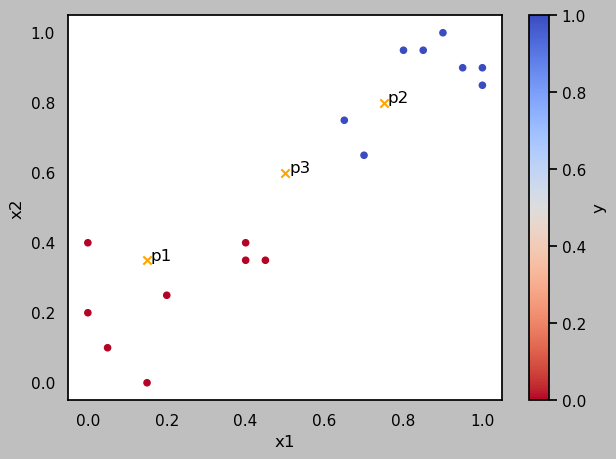

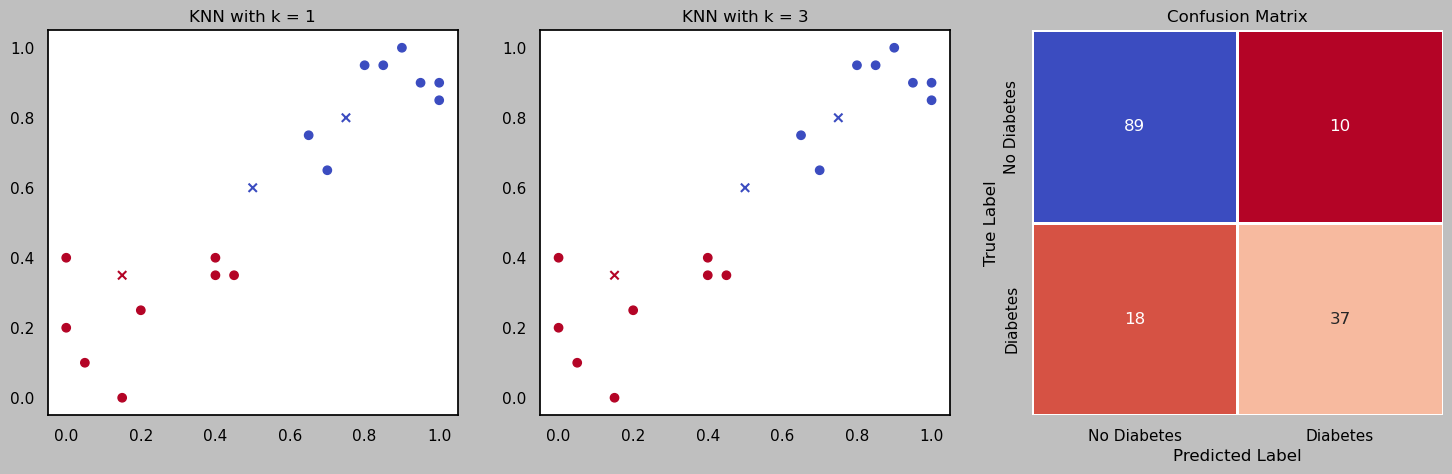

In [9]:
# Import additional libraries
# data splitting
from sklearn.model_selection import train_test_split
# data scaling
from sklearn.preprocessing import MinMaxScaler
# performance measures
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score,average_precision_score
# classifier
from sklearn.neighbors import KNeighborsClassifier
# set a random seed
np.random.seed(1)

df = pd.read_csv('DiabetesDataset.csv')
print(df.info)
# keep the patient characteristics as inputs x and the diabetes as target y
x = df.drop(columns=['Diabetes'])
y = df['Diabetes'].values
labels = ["No Diabetes", "Diabetes"]

#### START YOUR SOLUTION HERE ####
# Split data into training and test dataset
trainX, testX, trainy, testy = train_test_split(x, y, test_size=0.2)

# Define the data scaler
scaler = MinMaxScaler()

# Fit and transform the training set 
trainX = scaler.fit_transform(trainX)

# Transform the test set
testX = scaler.transform(testX)

# Fit kNN model with k=5 to the training data
model =  KNeighborsClassifier(n_neighbors=5).fit(trainX, trainy)

# # Get predictions on test set
pred = model.predict(testX)

# Compute the performance measures listed in the text above
conf = confusion_matrix(testy, pred)
acc = accuracy_score(testy, pred)
rec = recall_score(testy, pred)
prec = precision_score(testy, pred)
f1 = f1_score(testy, pred)

# Print the values of all performance measures except the confusion matrix 
print( "Performance measurements", "\n",
       "accuracy  : ", round(acc,3),"\n",
       "recall    : ", round(rec,3), "\n",
       "precision : ", round(prec,3),"\n",
       "f1-score  : ", round(f1,3))

# Display confusion matrix using a heatmap
sns.heatmap(conf, 
            annot=True, 
            fmt='d', 
            cbar=False, 
            cmap="coolwarm_r", 
            xticklabels=labels, 
            yticklabels=labels, 
            linewidth = 1)
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
#### END YOUR SOLUTION HERE ####


#### 2. Performance Curves
Compute the values necessary for plotting the area under the ROC and Precision-Recall curves and then plot and inspect the curves.

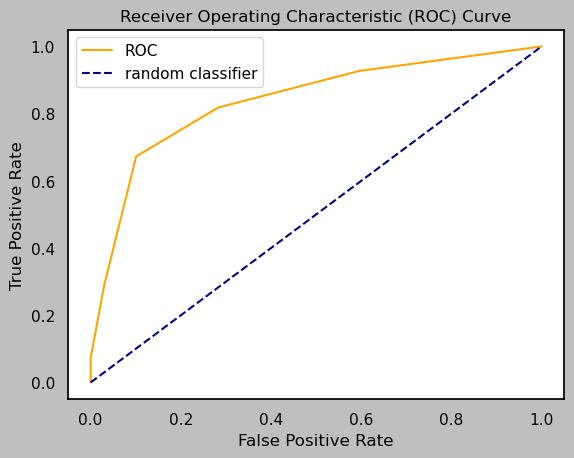

AUC:  0.838


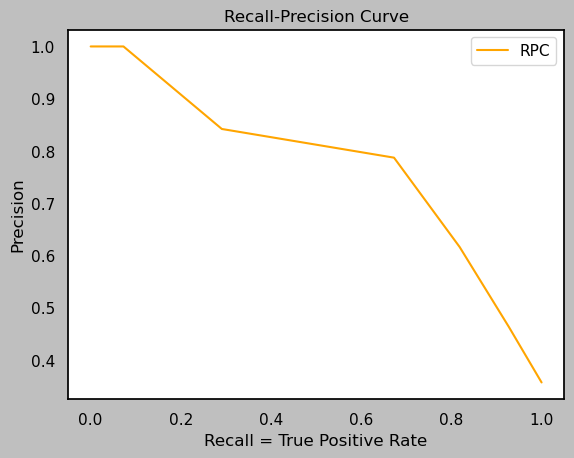

Average Precision:  0.723


In [15]:
# Predict probabilities for the test set
probs = model.predict_proba(testX)

# Keep the Probabilities of the positive class only
probs = probs[:, 1]

# Function for plotting the ROC curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label = 'random classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# Function for plotting the Precision-Recall curve
def plot_rpc(recall, precision):
    plt.plot(recall, precision, color='orange', label='RPC')
    plt.ylabel('Precision')
    plt.xlabel('Recall = True Positive Rate')
    plt.title('Recall-Precision Curve')
    plt.legend()
    plt.show()


#### START YOUR SOLUTION HERE ####
# Compute and plot ROC curve (check out the function roc_curve)
fpr, tpr, thresholds = roc_curve(testy, probs)
plot_roc_curve(fpr, tpr)

# Compute the Area Under the ROC Curve (AUC) - the ROC AUC score
auc = roc_auc_score(testy, probs)
print("AUC: ", round(auc, 3))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(testy, probs)
plot_rpc(recall, precision)

# Compute average precision - Precision-Recall AUC
average_precision = average_precision_score(testy, probs)
print("Average Precision: ", round(average_precision, 3))

#### END YOUR SOLUTION HERE ####

#### 3. Assignment: Different Values of k
Now fit two additional k-NN classifies to the same dataset with `k` values 1 and n (number of training samples), respectively. Compute the accuracies and plot the corresponding confusion matrix to analyze the prediction results for each model.

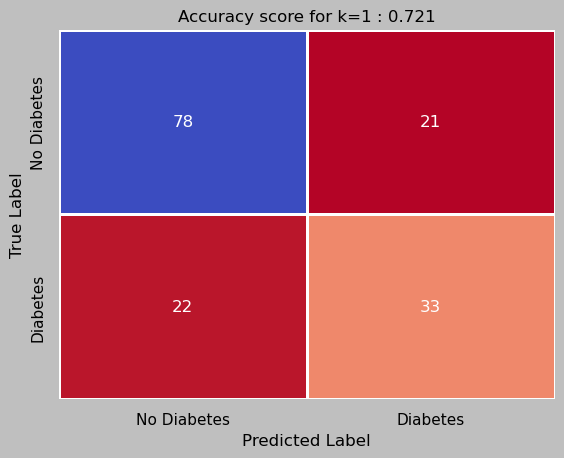

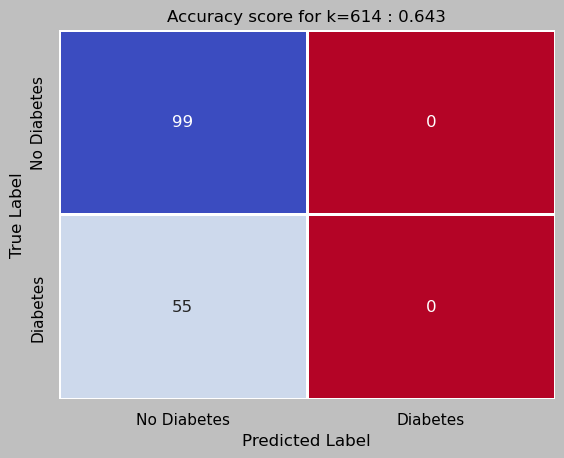

In [17]:
# Perform a k-NN on the given dataset and plot the confusion matrix
# compute number of samples
n = len(trainy)

for k in [1, n]:
    #### START YOUR SOLUTION HERE ####
    # Fit a kNN classifier
    knn = KNeighborsClassifier(n_neighbors=k).fit(trainX, trainy)
    # Compute the predictions on the test data using the trained model
    pred = knn.predict(testX)
    # Compute accuracy
    acc_score = accuracy_score(testy, pred)
    # Compute the confusion matrix
    conf = confusion_matrix(testy, pred)
    # Plot the confusion matrix using a heatmap
    sns.heatmap(conf, 
            annot=True, 
            fmt='d', 
            cbar=False, 
            cmap="coolwarm_r", 
            xticklabels=labels, 
            yticklabels=labels, 
            linewidth=1)
    plt.title('Accuracy score for k={} : {}'.format(k, round(acc_score, 3)))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    #### END YOUR SOLUTION HERE ####